In [2]:
import torch 
torch.cuda.is_available()
#conda activate하면 torch 가상환경 들어가구
#가상환경에서 jupyter notebook 입력해야함..!
#conda deactivate 하면 빠져온다

False

In [4]:
torch.__version__

'1.13.1'

In [7]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np


In [10]:
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor())
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor())

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [11]:
labels_map = {0: "T-shirt",1: "Trouser",2: "Pullover",3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle Boot"}

In [13]:
training_data[0][0].shape

torch.Size([1, 28, 28])

In [14]:
len(training_data)

60000

In [15]:
test_data[0][0].shape

torch.Size([1, 28, 28])

In [16]:
len(test_data)

10000

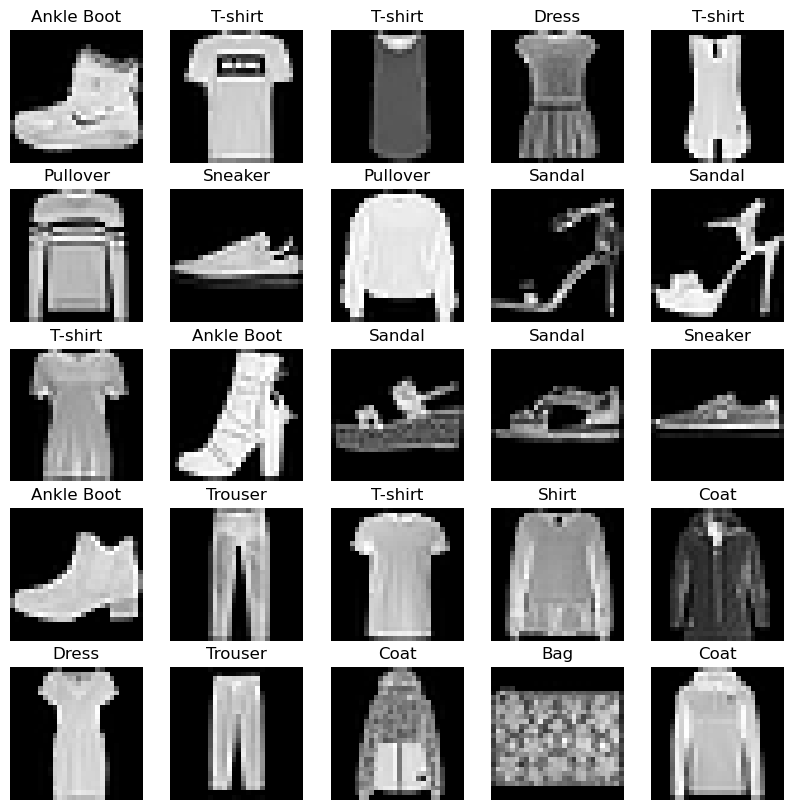

In [17]:
figure = plt.figure(figsize = (10,10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = i -1 
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap = "gray")
plt.show()

In [21]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size =batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X,y in test_dataloader:
    print("Shape of X [N,C,H,W]:",X.shape)
    print("Shape of y:",y.shape, y.dtype)
    break

model =nn.Sequential(
    nn.Linear(32,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,10),
    nn.Softmax()
)

Shape of X [N,C,H,W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using{device}device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()  # 2차원을 1차원으로 변환하는거임(ex 28 * 28 -> 784)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        
model = NeuralNetwork().to(device)
print(model)

usingcpudevice
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [43]:
loss_fn =nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 ==0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:7f} [{current:>5d}/{size:>5d}]")

In [44]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) ==y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
 

In [45]:
epochs = 5
for t in range(epochs):
    print(f"Epoch{t+1}\n----------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done")

Epoch1
----------------------
loss: 2.301956 [    0/60000]
loss: 0.495369 [ 6400/60000]
loss: 0.415915 [12800/60000]
loss: 0.522717 [19200/60000]
loss: 0.518588 [25600/60000]
loss: 0.406513 [32000/60000]
loss: 0.371174 [38400/60000]
loss: 0.510067 [44800/60000]
loss: 0.481579 [51200/60000]
loss: 0.555969 [57600/60000]
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.427257 

Epoch2
----------------------
loss: 0.272121 [    0/60000]
loss: 0.379262 [ 6400/60000]
loss: 0.317369 [12800/60000]
loss: 0.399995 [19200/60000]
loss: 0.456959 [25600/60000]
loss: 0.503357 [32000/60000]
loss: 0.314573 [38400/60000]
loss: 0.516587 [44800/60000]
loss: 0.428843 [51200/60000]
loss: 0.484618 [57600/60000]
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.438558 

Epoch3
----------------------
loss: 0.319362 [    0/60000]
loss: 0.294349 [ 6400/60000]
loss: 0.246478 [12800/60000]
loss: 0.307257 [19200/60000]
loss: 0.463562 [25600/60000]
loss: 0.383348 [32000/60000]
loss: 0.292804 [38400/60000]
loss: 0.508934 [44800/6

In [46]:
with torch.no_grad():
    predictions = [model(X.to(device))[0] for X,y in test_data]
predictions[0]

tensor([ -8.6292,  -9.5483, -10.8680, -14.1162, -14.7652,  -0.4317,  -9.8470,
          0.0954,  -6.3269,   3.7095])

In [ ]:
def plot_image(i, predictions_array, data):
    predictions_array, true_label, img = predictions_array[i].cpu().numpy(),data[i][1],data[i][0].squeeze()
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img. cmap=plt.cm.binary)
    plt.imshow(img, cmap = plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label = true_label:
        color = "blue"
    else:
        color = "red"
    plt.xlabel("{} {:2.0f}% ({})".format(labels_map[predicted_label],
                                         100*np.max(predictions_array),
                                         labels_map[true_label],
                                         color = color)
    def plot_value_array(i, predictions_array, data):
        predictions_array, true_label = predictions_array[1]
                                           
    
    